<a href="https://colab.research.google.com/github/LeeJungtae/TensorflowProject1/blob/main/TensorflowProject5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번에는 자동차의 연비를 예측하는 모델을 만들어볼 것이다.

회귀(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적이다.\
이것과 달리 분류(classification)는 여러 개의 클래스 중 하나의 클래스를 선택하는 것이 목적이다.

Auto MPG 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만든다.

In [1]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치한다
!pip install -q seaborn

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


먼저 데이터셋을 다운받도록 하자.

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

판다스를 사용하여 데이터를 읽는다.

In [4]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight",
                "Acceleration", "Model Year", "Origin"]
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values="?", comment="\t",
                          sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


이 데이터셋은 일부 데이터가 누락되어 있다.

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

문제를 간단하게 하기 위해 누락된 행을 삭제하자.

In [6]:
dataset = dataset.dropna()

"Origin" 열은 number가 아닌 range이므로 원-핫 인코딩으로 변환하자.

In [7]:
origin = dataset.pop("Origin")

In [8]:
dataset["USA"] = (origin == 1) * 1.0
dataset["Europe"] = (origin == 2) * 1.0
dataset["Japan"] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


이제 데이터를 훈련 세트와 테스트 세트로 분할하자.\
테스트 세트는 모델을 최종적으로 평가할 때 사용한다.

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 만들어 살펴보도록 하자.

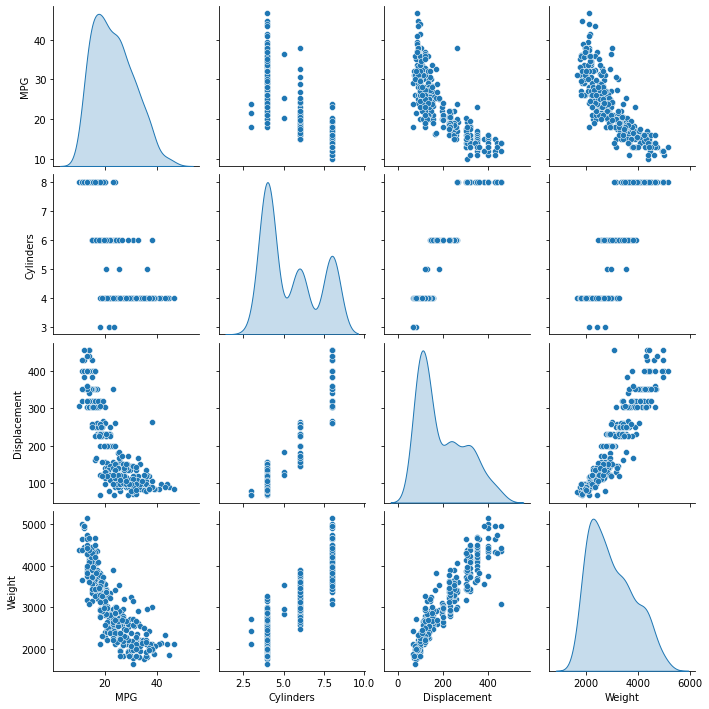

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

전반적인 통계 또한 확인해보자.

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


특성에서 목표값 또는 "레이블"을 분리한다.\
이 레이블을 예측하기 위해 모델을 훈련시킬 것이다.

In [12]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장된다.\
특성을 정규화하지 않아도 모델이 수렴할 수는 있으나,\
훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어진다.

참고: 의도적으로 훈련 세트만 사용하여 통계치를 생성했다.\
이 통계는 테스트 세트를 정규화할 땓도 사용된다.\
이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서이다.

In [13]:
def norm(x):
  return (x - train_stats["mean"]) / train_stats["std"]
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

정규화된 데이터를 사용하여 모델을 훈련한다.

이제 모델을 구성해보자.\
어제도 했도 그저께도 했는데 아직 낯설다.\
그만큼 더 반복해야겠지.

두 개의 완전 연결 은닉층으로 Sequential 모델을 만들자.\
출력 층은 하나의 연속적인 값을 반환한다.\
나중에 두 번째 모델을 만들기 쉽도록 build_model 함수로 모델 구성 단계를 감싸자.

In [14]:
def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])
  optimizer = keras.optimizers.RMSprop(0.001)
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=["mae", "mse"])
  return model

In [15]:
model = build_model()

.summary 메소드를 사용해 모델에 대한 간단한 정보를 출력해보자.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


모델을 한 번 실행해보자.\
훈련 세트에서 열 개의 샘플을 하나의 배치로 만들어 model.predict 메소드를 호출해보도록 하겠다.

In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.5492945 ],
       [-0.32422352],
       [ 0.04273951],
       [-0.5513689 ],
       [-0.7158664 ],
       [-0.11448836],
       [-0.7828138 ],
       [-0.5827405 ],
       [-0.04270434],
       [-0.8246747 ]], dtype=float32)

이 모델을 1,000번의 에포크(epoch) 동안 훈련한다.\
훈련 정확도와 검증 정확도는 history 객체에 기록된다.

In [18]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시한다.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      print('')
    print('.', end='')
EPOCHS = 1000
history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

history 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화해보자.

In [19]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.312610,0.951795,2.312610,8.839592,2.334643,8.839592,995
996,2.310410,1.011466,2.310410,8.143188,2.241953,8.143188,996
997,2.229171,0.929649,2.229171,8.626328,2.349503,8.626328,997
998,2.244382,0.936813,2.244382,7.993966,2.214778,7.993966,998
999,2.333652,0.941645,2.333652,8.109397,2.198342,8.109397,999


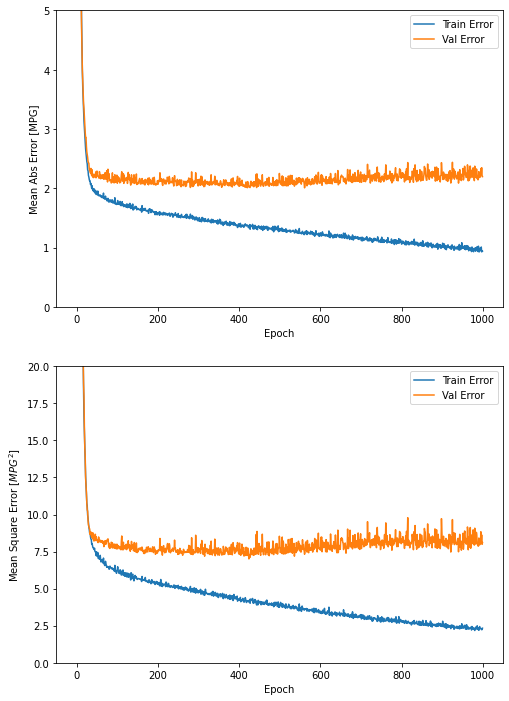

In [22]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist["epoch"] = history.epoch
  
  plt.figure(figsize=(8, 12))

  plt.subplot(2, 1, 1)
  plt.xlabel("Epoch")
  plt.ylabel("Mean Abs Error [MPG]")
  plt.plot(hist["epoch"], hist["mae"], label="Train Error")
  plt.plot(hist["epoch"], hist["val_mae"], label="Val Error")
  plt.ylim([0, 5])
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.xlabel("Epoch")
  plt.ylabel("Mean Square Error [$MPG^2$]")
  plt.plot(hist["epoch"], hist["mse"], label="Train Error")
  plt.plot(hist["epoch"], hist["val_mse"], label="Val Error")
  plt.ylim([0, 20])
  plt.legend()

  plt.show()

plot_history(history)

음...아주 미묘하게 차이는 있다.\
그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는다.\
model.fit 메소드를 수정해서 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 개선해보자.\
에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백(callback)을 사용하려고 한다.\
지정된 에포크 횟수 동안 성능 향상이 이뤄지지 않으면 자동으로 훈련이 멈춘다.


..........................................................

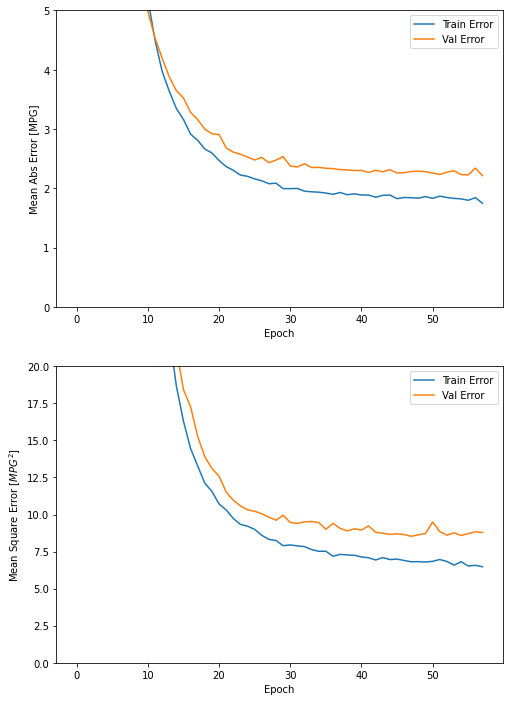

In [23]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

history = model.fit(
  normed_train_data,
  train_labels,
  epochs=EPOCHS,
  validation_split=0.2,
  verbose=0,
  callbacks=[early_stop, PrintDot()]
)

plot_history(history)

점이 찍히다가 말았다.\
더 이상의 검증에 의미가 없다고 판단하고 검증을 멈춘 것이다.

이 그래프를 보면 검증 세트의 평균 오차가 약 +/- 2MPG이다.

모델을 훈련할 때 사용하지 않았던 테스트 세트에서 모델의 성능을 확인해보자.\
이를 통해 모델이 실전에 투입되었을 때 모델의 성능을 짐작할 수 있다.

In [24]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.2582 - mae: 1.9704 - mse: 6.2582
테스트 세트의 평균 절대 오차:  1.97 MPG


마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해보겠다.

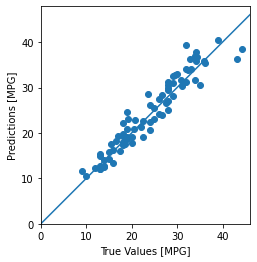

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
plt.axis("equal")
plt.axis("square")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

모델이 잘 예측한 것 같다.\
오차의 분포 또한 살펴보자.

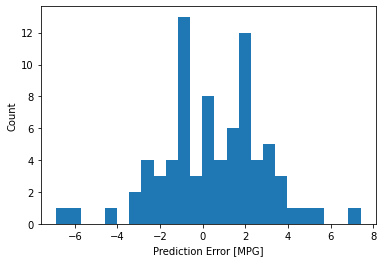

In [26]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

이 과정을 통해 얻은 결론.\
회귀 문제에 대한 기법을 알 수 있었다.

- 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수이다.(분류 문제에서 사용하는 손실 함수와는 다르다.)

- 비슷하게 회귀에서 사용되는 평가 지표도 분류와 다르다. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)이다.

- 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 한다.

- 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋다.

- 조기 종료(Early Stopping)은 과대적합을 방지하기 위한 좋은 방법이다.